We extend the implementation to estimate the parameters of a multivariate Gaussian. Here we use the analytical gradients and hessians to speedup computation. We notice however that (especially with higher dimension Gaussian n > 6), the algorithm may not converge. We postulate that the problem is with the density of samples that we have access to and how far they are from our initial estimate. Of course, it doesn't make sense to initialize the Gaussian distribution estimate to be too far away from the samples i.e. we are trying to answer the following question: if our samples are concentrated around low probability regions of our initial estimated pdf, how is convergence affected? The loss is: $$\mathbb{E}_{x \sim p_\mathbf{x}}\left[ trace(\nabla_{xx} \log(q(x, \theta)) + \frac{1}{2} || \nabla_{x} \log(q(x, \theta)) ||_2^2                     \right]$$
So of course if the $trace(\nabla_{xx} \log(q(x, \theta))) $ and $\nabla_{x} \log(q(x, \theta)$ are small in value, the gradient will essentially be very small and not much "learning" will happen.  But for the sake of experimentation, let's do verify this experimentally that for a 2D Gaussian.

In [285]:
import numpy as np
import torch
from torch.optim import Adam
import random 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
import scipy.stats
from scipy.linalg import sqrtm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pi = torch.from_numpy(np.array([np.pi]))


In [286]:
# Implement the analytical gradient and hessian of q 

def logq(x, mean, cov, n):
    mean = mean.mT
    mean = mean.repeat((n, 1))
    x = x.unsqueeze(dim=1)
    mean = mean.unsqueeze(dim=1)
    return (-1/2) * ((x - mean) @ torch.linalg.inv(cov) @ torch.transpose(x - mean, 2, 1))

def gradlogq(x, mean, cov, n):
    mean = mean.mT
    mean = mean.repeat((n, 1))
    x = x.unsqueeze(dim=1)
    mean = mean.unsqueeze(dim=1)
    return (-1) * ((x - mean) @ torch.linalg.inv(cov) ).squeeze()

def hessianlogq(x, mean, cov, n):
    mean = mean.mT
    mean = mean.repeat((n, 1))
    x = x.unsqueeze(dim=1)
    mean = mean.unsqueeze(dim=1)
    res = (-1) * torch.linalg.inv(cov)
    return res.repeat((n, 1, 1))

In [287]:
def scoreMatchingLoss(grad, hessian):
    trace = hessian.diagonal(offset=0, dim1=-1, dim2=-2).sum(dim=1).to(device)
    grad = torch.linalg.norm(grad, dim=1)
    loss = torch.mean( trace + 1/2 * grad**2)
    return loss 

In [288]:
def jensen_shannon_divergence(p, q):
    p = np.array(p)
    q = np.array(q)
    m = (p + q) / 2
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    distance = np.sqrt(divergence)
    return distance

In [289]:
def frechet_distance(mean_true, cov_true, mean_estimated, cov_estimated):
    ssdiff = np.sum((mean_true - mean_estimated)**2.0)
    covmean = sqrtm(cov_true.dot(cov_estimated))
    return ssdiff + np.trace(cov_true + cov_estimated - 2.0 * covmean)

In [290]:
## Init params 

# dimensionality of the gaussian
dim = 2
# number of samples
n = 1000
# learning rate 
learning_rate = 0.1
# number of optimization steps
max_steps = 100000
max_mean = 15

In [293]:

# init our target distribution params (mean and covariance)

mean_true = np.array([random.randint(1, max_mean) for x in range(dim)])
A = np.random.rand(dim, dim)
cov_true = np.dot(A, A.transpose())

cov_true_tensor = torch.from_numpy(cov_true).to(device)
mean_true_tensor = torch.from_numpy(mean_true).to(device)

# sample from distribution. The objective is to estimate the parameters of the original gaussian
# from these samples 
samples_from_target = np.random.multivariate_normal(mean_true, cov_true, size=n)
x = torch.from_numpy(samples_from_target).double().requires_grad_().to(device)

# define training parameters and setup the optimizer
L0 = torch.triu(torch.rand(dim, dim))
L = torch.nn.Parameter(L0.to(device).double()).requires_grad_()

mean = torch.nn.Parameter(torch.zeros(dim,1).to(device).double()).requires_grad_()
params_to_train = [L, mean]

optimizer = Adam(params_to_train, learning_rate)

cov_estimated = torch.matmul(L.mT, L).detach().cpu().numpy()
mean_estimated = mean.detach().cpu().numpy().squeeze()
eigenval, eigenvec = np.linalg.eig(cov_true)
ratioEigenvalues = np.max(eigenval)/np.min(eigenval)

if dim == 2:
    print("frechet distance {}".format(frechet_distance(mean_true, cov_true, mean_estimated, cov_estimated)))
    print("ratio of max to min eigenvalue {}".format(ratioEigenvalues))
# samples_from_init = np.random.multivariate_normal(mean_estimated, cov_estimated, size=n)
# print(jensen_shannon_divergence(samples_from_target, samples_from_init))




frechet distance 82.03574028220866
ratio of max to min eigenvalue 416.18736539060217


## Analyzing convergence issues

### Correlation between frechet distance and probability of convergence (not really)
Does convergence depend on the distance between the target and our initial guess (plot Frechet distance vs probability of convergence)? Technically, a more proper analysis should be done using the distance between the discrete sample distribution and our initial guess 
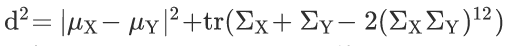
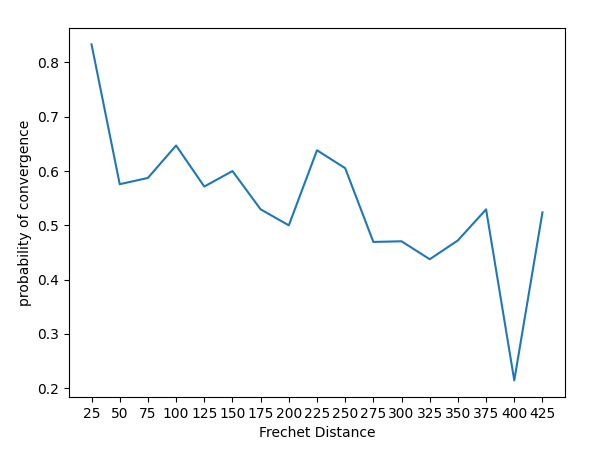

There is no real correlation

### Correlation between ratio of eigenvalue and probability of convergence (more likely)
Does convergence depend on the variability of the samples along its principal components? Take the spectral decomposition of the covariance matrix to get the two eigenvalues: $\lambda_1$ and $\lambda_2$. Plot probability of convergence vs $\frac{\max(\lambda_1, \lambda_2)}{\min(\lambda_1, \lambda_2)}$

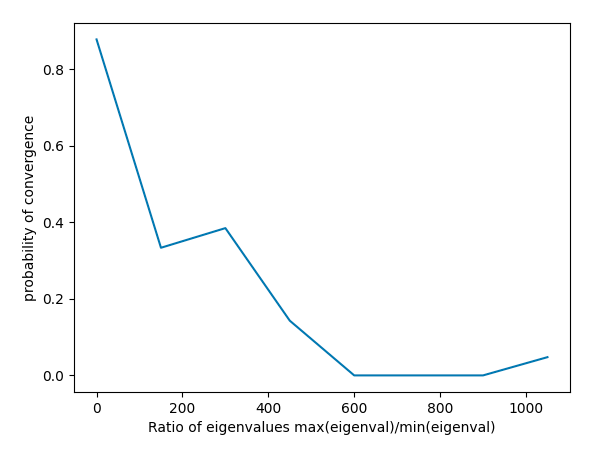

This seems more likely (might be related to why it is always advisable to normalize your data by sustracting the mean and divide by the variance but if we do that here we are essentially changing the space over which we are taking the gradients/hessians..)

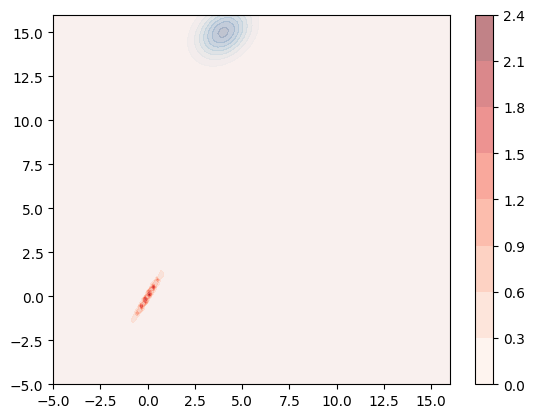

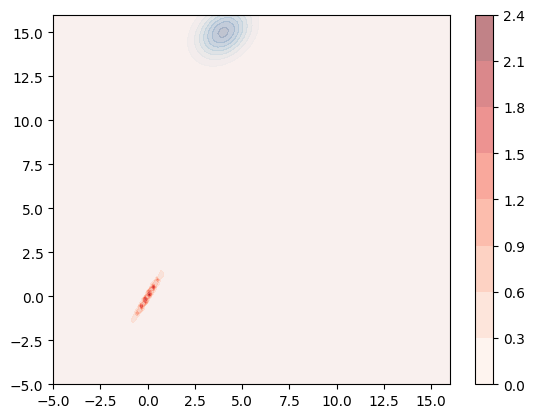

In [282]:
if dim == 2:
    def plot_init(mean_estimated, cov_estimated):
        plt.clf()
        size = 100
        x = np.linspace(-5, max_mean+1, size)
        y = np.linspace(-5, max_mean+1, size)
        x, y = np.meshgrid(x, y)
        pos = np.dstack((x, y))
        z1 = multivariate_normal.pdf(pos, mean=mean_true, cov=cov_true)
        z2 = multivariate_normal.pdf(pos, mean=mean_estimated, cov=cov_estimated)
        plt.contourf(x, y, z1, cmap='Blues', alpha=0.5)
        plt.contourf(x, y, z2, cmap='Reds', alpha=0.5)
        plt.colorbar()
        display.clear_output(wait=True)
        display.display(plt.gcf())
    plot_init(mean_estimated, cov_estimated)

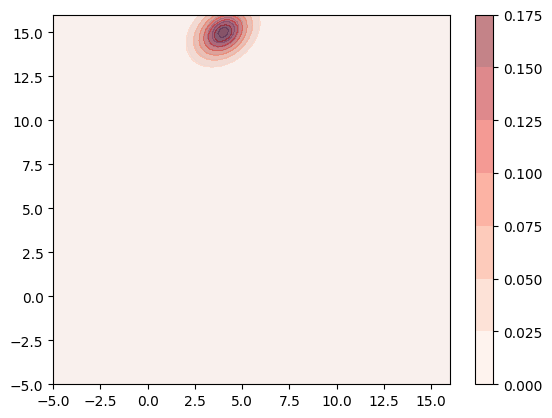

cov_true [[0.88549288 0.26494061]
 [0.26494061 0.92555029]]
cov_estimated [[1.00094265 0.29641259]
 [0.29641259 0.97704894]]


mean_true [ 4 15]
mean_estimated [[ 3.98785299]
 [14.95465549]]


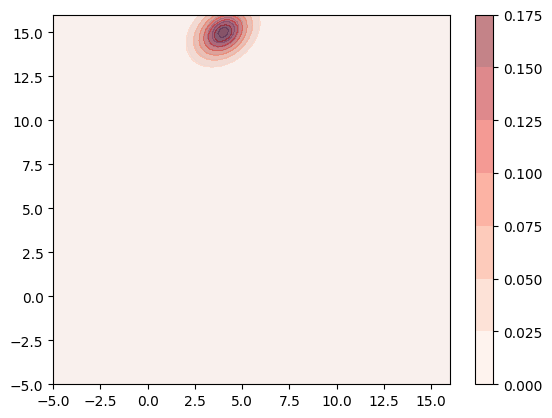

In [283]:
verbose = True

for t in range(max_steps):
    optimizer.zero_grad()
    cov = torch.matmul(L.mT, L)
    q = logq(x, mean, cov, n)
    phi = gradlogq(x, mean, cov, n)
    gradPhi = hessianlogq(x, mean, cov, n)
    loss = scoreMatchingLoss(phi, gradPhi)
    loss.backward()
    optimizer.step()        
    if (t%1000 == 0):
        matrix_norm_err = torch.linalg.norm(cov_true_tensor - cov)
        mean_norm_err = torch.linalg.norm(mean_true_tensor - mean.squeeze())
        #clear_output(wait=True)
        if verbose:
            print("t={} loss={}".format(t, loss))
            print("cov_true {}".format(cov_true), "cov_estimated {}".format(cov))
            print("\n")
            print("mean_true {}".format(mean_true), "mean_estimated {}".format(mean))
            print("matrix norm error {}".format(matrix_norm_err))
            print("mean norm error {}".format(mean_norm_err))
        if dim == 2:
            cov_estimated = torch.matmul(L.mT, L).detach().cpu().numpy()
            mean_estimated = mean.detach().cpu().numpy().squeeze()
            plot_init(mean_estimated, cov_estimated)
        if matrix_norm_err < 0.5 and mean_norm_err < 0.1:       
            break



print("cov_true {}".format(cov_true))
print("cov_estimated {}".format(cov.cpu().detach().numpy()))
print("\n")
print("mean_true {}".format(mean_true))
print("mean_estimated {}".format(mean.cpu().detach().numpy()))